In [1]:
import qutip as qt
import numpy as np

# Tracking info of simulations 
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec

In [2]:
import sys
sys.path.append('/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/src')

import model_building as md
import Hamiltonian as Ham
import dynamics as dyn
import data_handling as dh
import plots as plots



# Initial test

In [3]:
# Define parameters
N=10
lmd = 0.02272
J = 0.5
state_dictionary = {"1":1}
#state_dictionary = {"1":1, "0":1}

ti = 0
tf = 150
Nsteps = 500

In [4]:
# Define intial and target systems
initial_state_DW, target_state_DW, register_size = md.create_DW_initial_and_target(state_dictionary, N, one_step = False)

In [5]:
#    def __init__(self, system_size, mode, lambda_factor, register_size=None, global_J=None,
#                 j_error = None, z_error = None, l_error = None):


H_t = Ham.Hamiltonian(system_size = N,
                    mode = "transport",
                    lambda_factor = lmd,
                    global_J = J,
                    j_error = 0.0,
                    l_error = 0.1,
                    z_error = 0.0
                    )
H_r = Ham.Hamiltonian(system_size = N,
                    mode = "reset",
                    lambda_factor = lmd,
                    register_size = register_size,
                    global_J = J,
                    j_error = 0.0,
                    l_error = 0.1,
                    z_error = 0.0
                    )

0.1 0.0 0.0
0.1 0.0 0.0


In [6]:
# Calibrate chain under ideal circumstances
transport_steps, transport_time = dyn.chain_calibration(initial_state_DW, H_t, ti, tf, Nsteps)

print(transport_steps, transport_time)

449 134.7


In [7]:
# test that algorithm works well without errors
fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_state_DW, target_state_DW, H_t, H_r, ti, transport_time, transport_steps, factor = 1.12)

print(max(fidelity))

0.8512494153092087


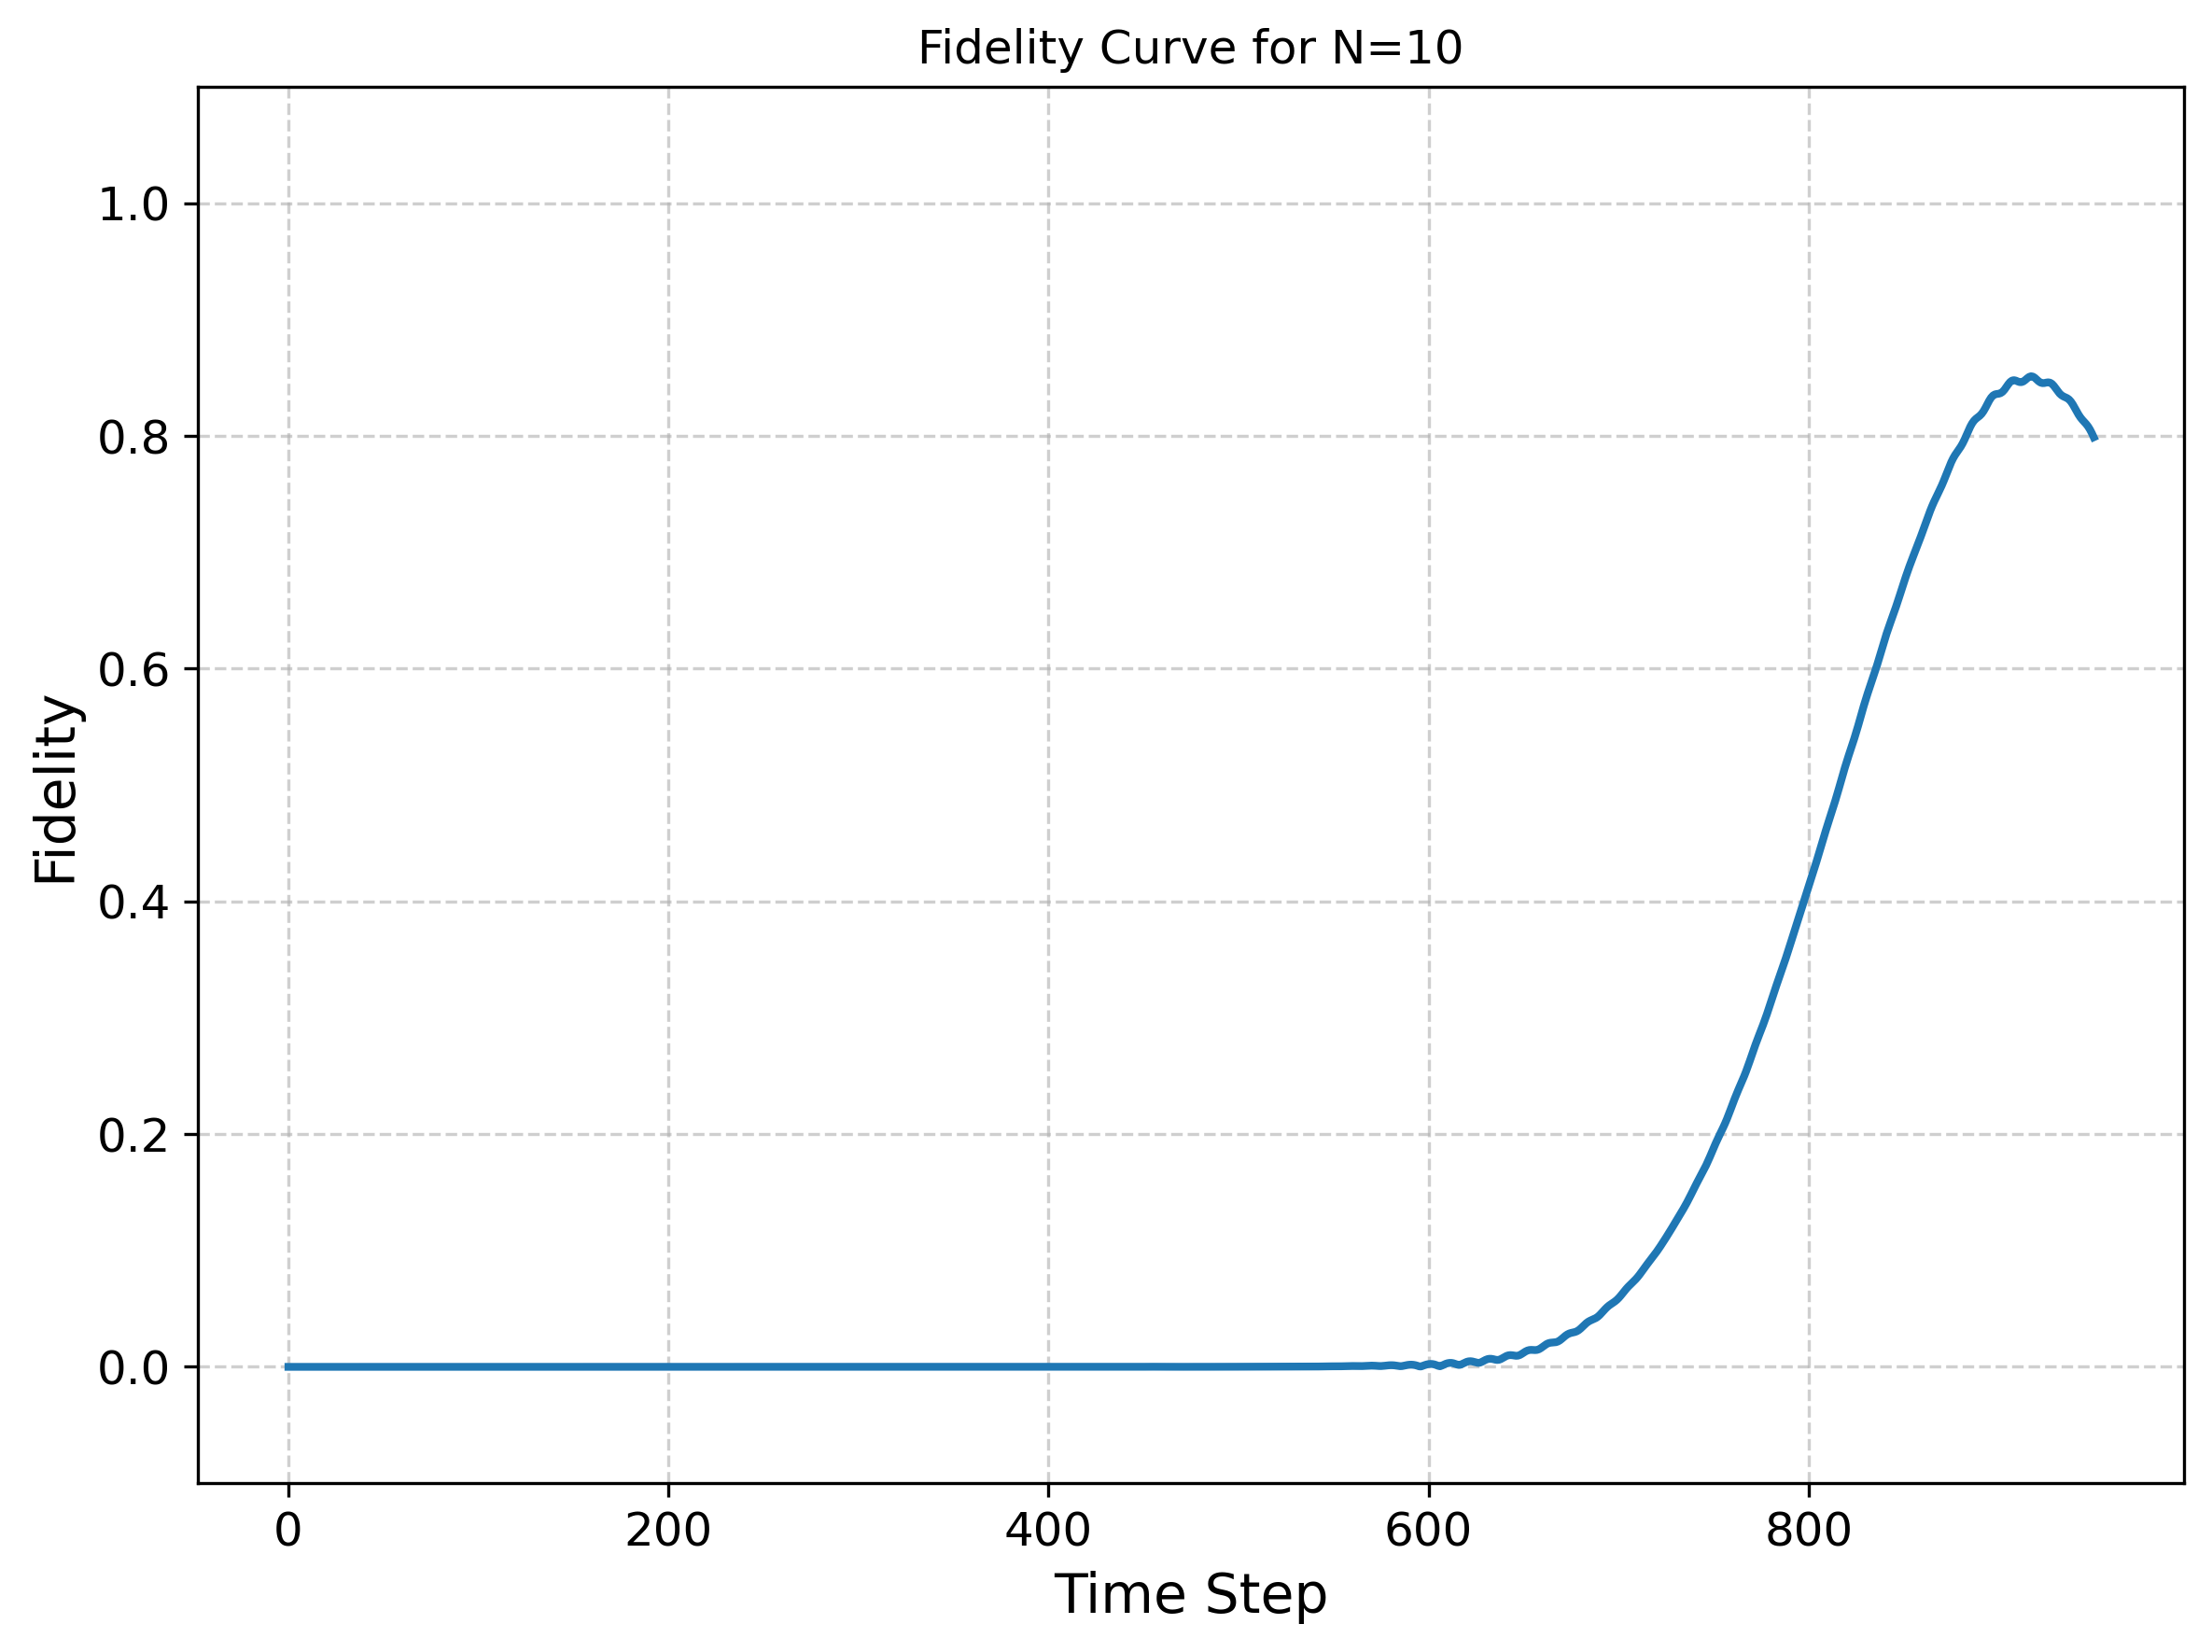

In [8]:
#Test plots
plots.plot_fidelity(fidelity, N)

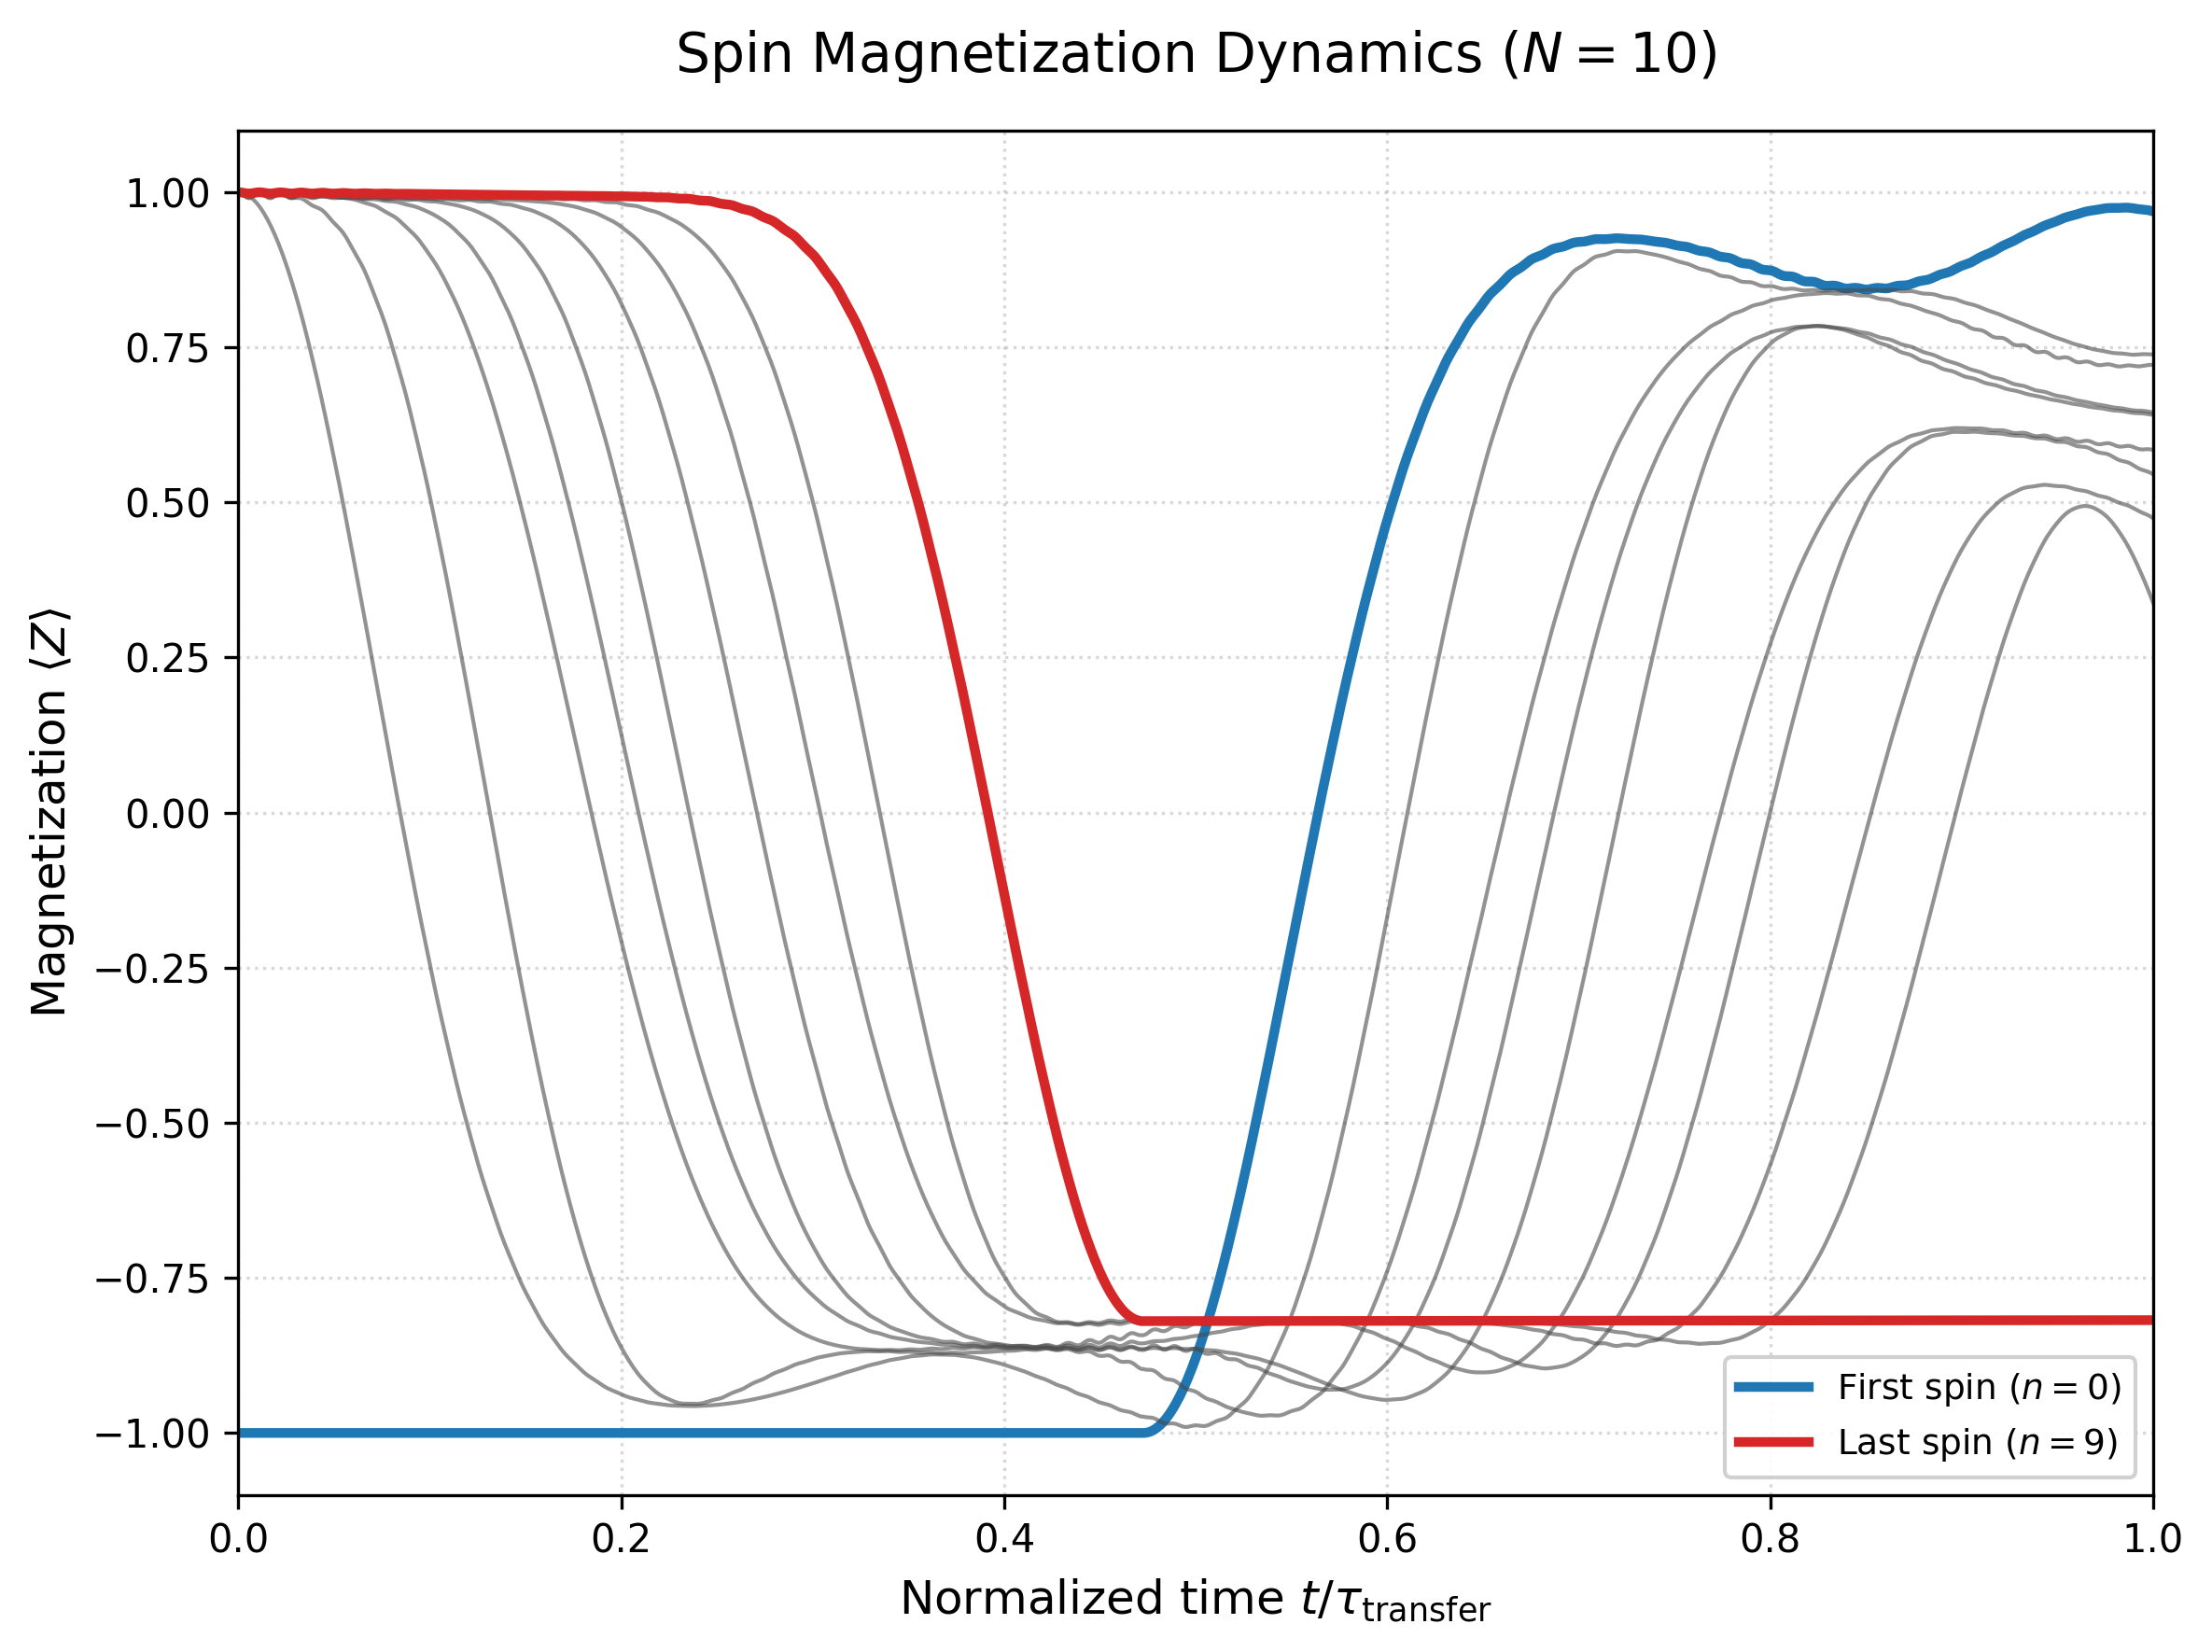

In [9]:
#Test plots
plots.plot_expectations(magnetizations["Sz"], N)

# Loop test

In [3]:
N=8
lmd = 0.02272
J = 0.5
state_dictionary = {"1":1}

ti = 0
tf = 200
Nsteps = 500

In [4]:
initial_state_DW, target_state_DW, register_size = md.create_DW_initial_and_target(state_dictionary, N, one_step = False)

In [5]:
# Define Hamiltonian without errors
H_t_noerror = Ham.Hamiltonian(system_size = N,
                    mode = "transport",
                    lambda_factor = lmd,
                    global_J = J
                    )

In [6]:
# Calibrate chain under ideal circumstances
transport_steps, transport_time = dyn.chain_calibration(initial_state_DW, H_t_noerror, ti, tf, Nsteps)

print(transport_steps, transport_time)

345 138.0


In [ ]:
def select_error(err, error_type):
    if error_type == "j":
        return err, 0, 0
    elif error_type == "l":
        return 0, err, 0
    elif error_type == "z":
         return 0, 0, err
    else:
        raise ValueError(f"{error_type} is not a valid type of error, only \'j\', \'l\', and \'z\' allowed")

def error_loop(N, lmd, J, ti, tf, Nsteps, Nshots, error_list, error_type, register_size = None):
    fidelities = []
    for err in error_list:
        avg = 0
        for _ in range(Nshots):

            j_err, l_err, z_err = select_error(err, error_type)

            #Run simulations, add fidelities, and save average of n_shots
            H_t, H_r = Ham.build_hamiltonians(N, lmd, J, register_size, j_err, l_err, z_err)
            fidelity = dyn.LightweightAlgorithm(initial_state_DW, target_state_DW, ti, tf, Nsteps, H_t, H_r)
            avg += fidelity

        fidelities.append(avg/Nshots)

    return fidelities


In [22]:
l_errors = np.linspace(0.01, 0.1, 21)
fidelities = []
Nshots = 10

fidelities = error_loop(N, lmd, J, ti, transport_time, Nsteps, Nshots, l_errors, "l", register_size)


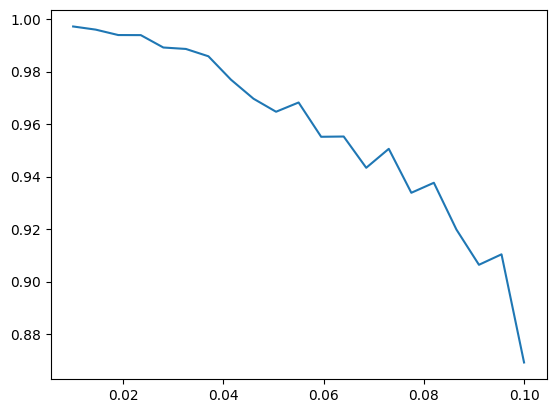

In [23]:
plt.plot(l_errors, fidelities)

# One-step

In [ ]:
N=8
lmd = 0.02272
J = 0.5
state_dictionary = {"1":1}

ti = 0
tf = 200
Nsteps = 500

# Standard encoding

In [15]:
# Define parameters
N=11
lmd = 0.02272
J = 0.5

state_dictionary = {"1":1, "0":1}

ti = 0
tf = np.pi/lmd
Nsteps = 500

In [16]:
initial_state_ST, target_state_ST = md.create_ST_initial_and_target(state_dictionary, N)

# Standard version
H_s = Ham.Hamiltonian(system_size = N,
                    mode = "standard",
                    lambda_factor = lmd,
                    l_error = 0.001,
                    z_error = 0.005
                    )


0.001 None 0.005


In [17]:
# test that algorithm works well without errors
fidelity, magnetizations, corrected_fidelity = dyn.OneStepAlgorithm(initial_state_ST, target_state_ST, H_s, ti, tf, Nsteps, factor = 1.00)


print(max(fidelity))
print(fidelity[-1])

0.9345032691123409
0.9345032691123409


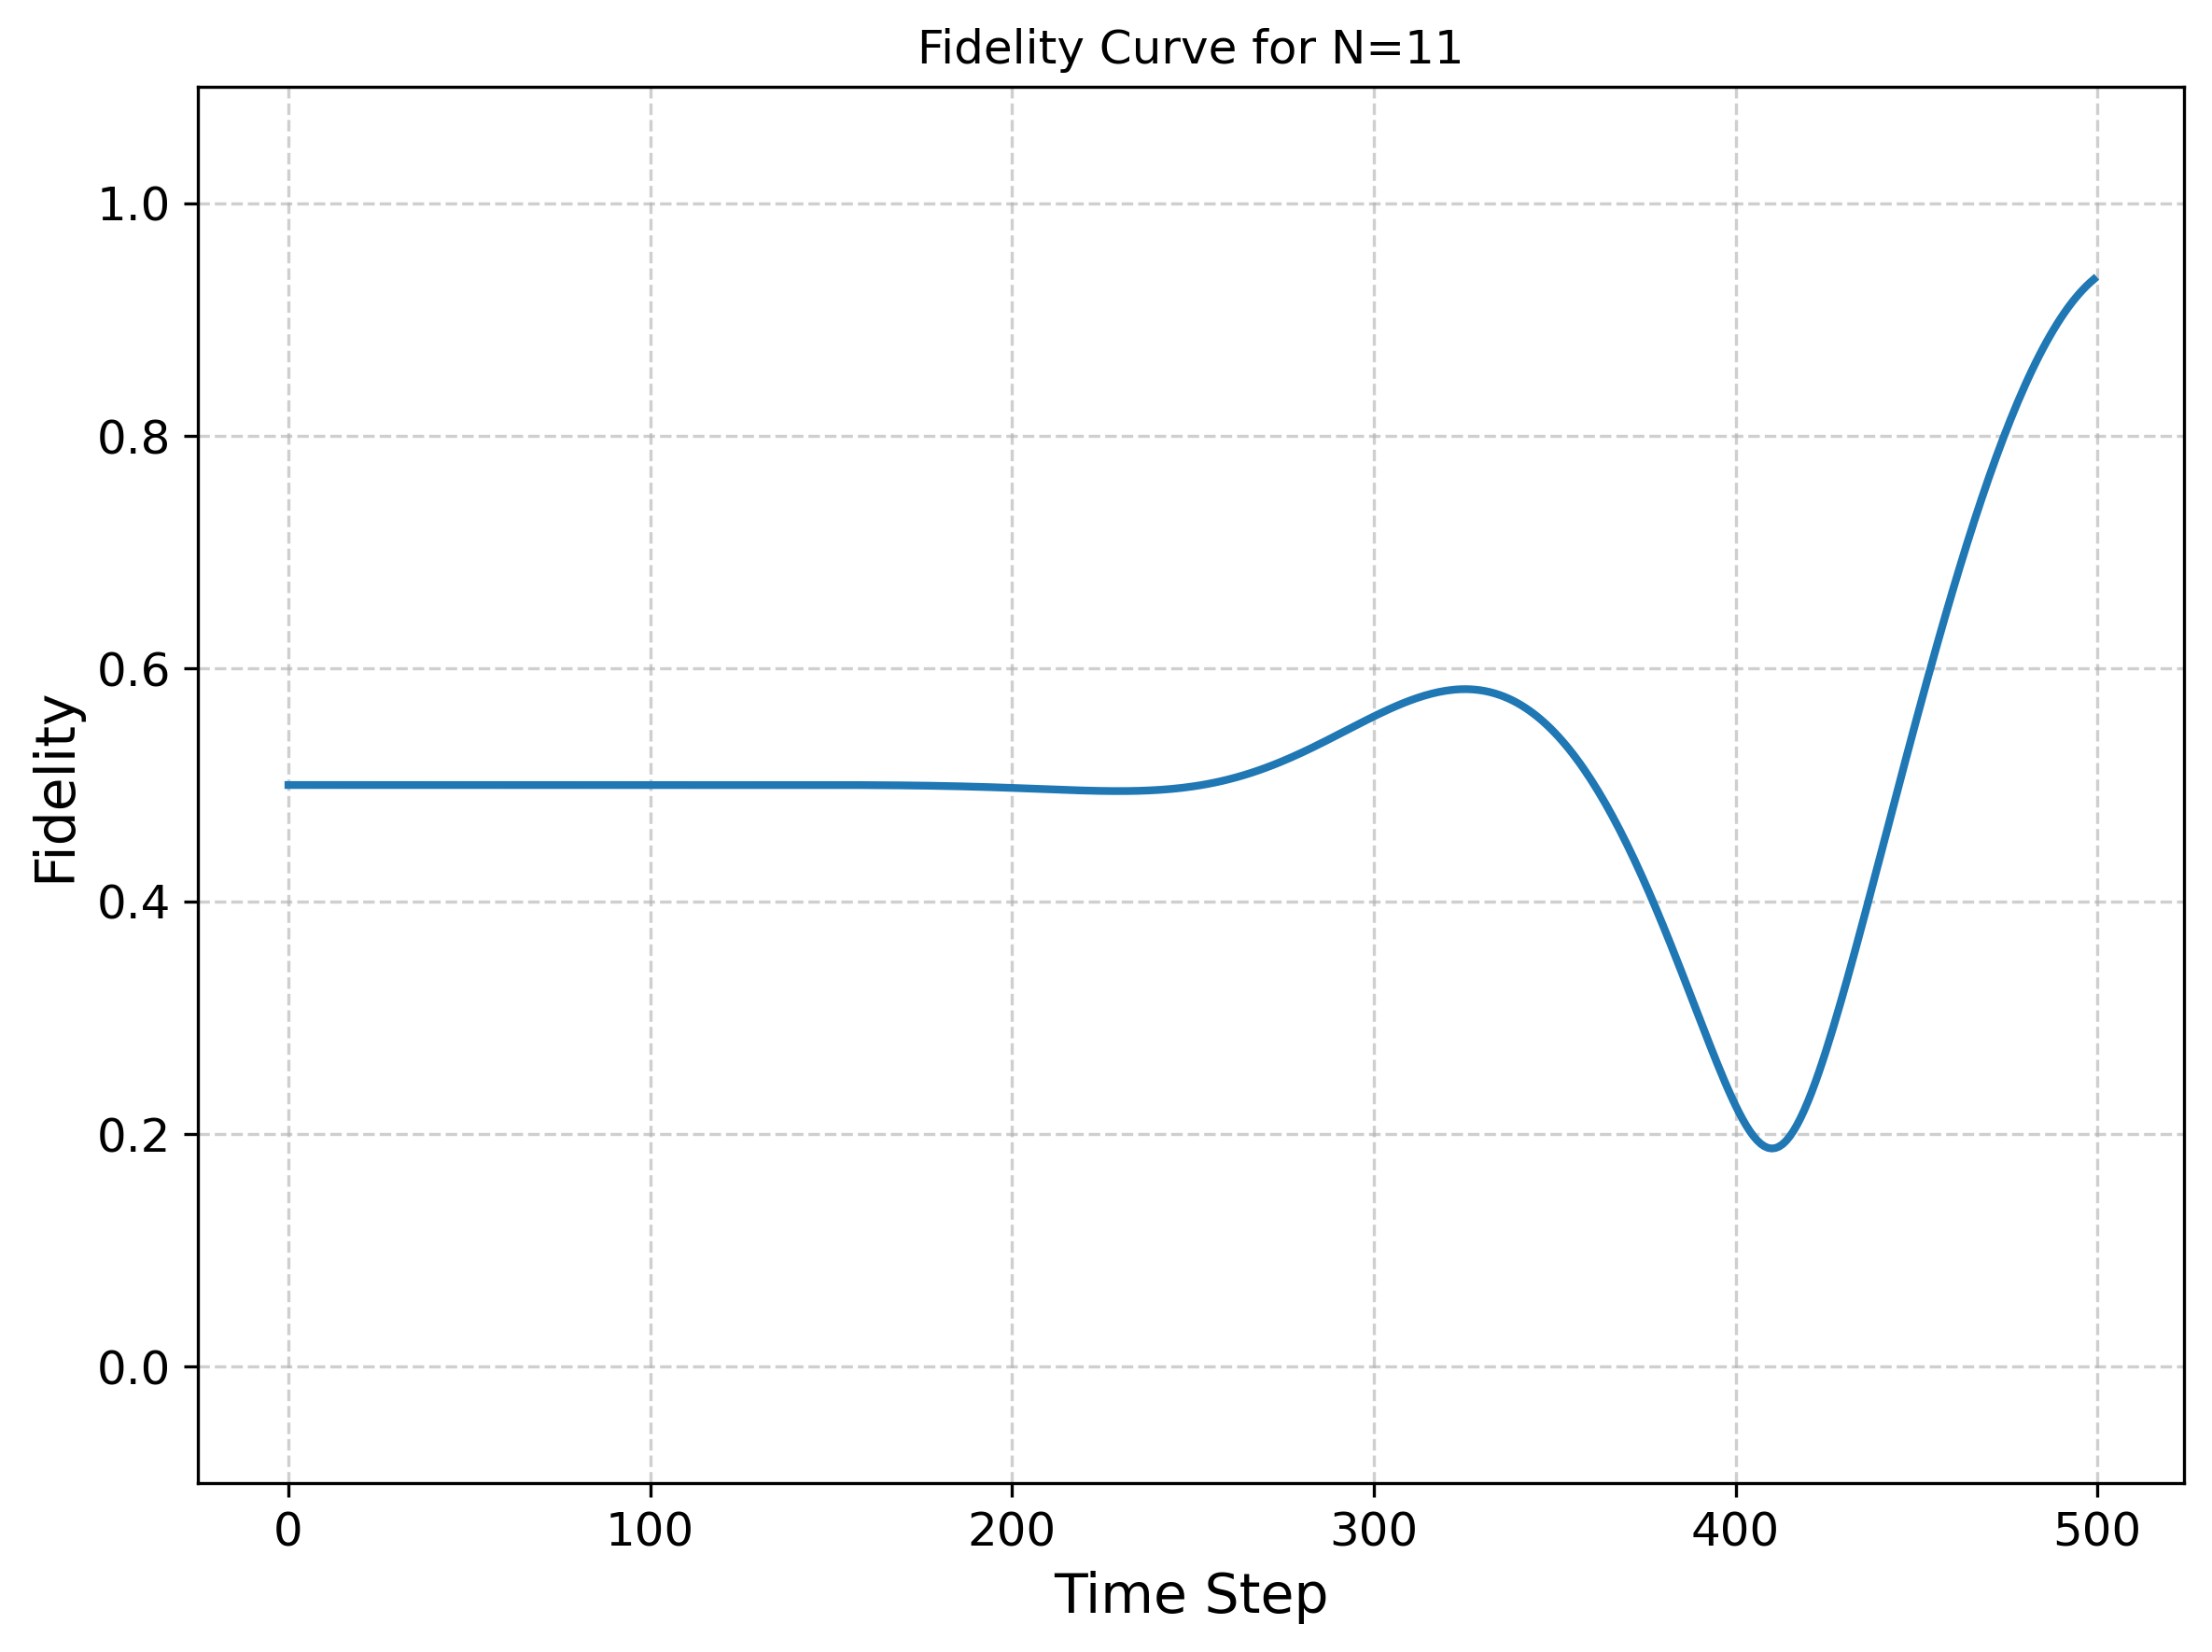

In [18]:
#Test plots
plots.plot_fidelity(fidelity, N)

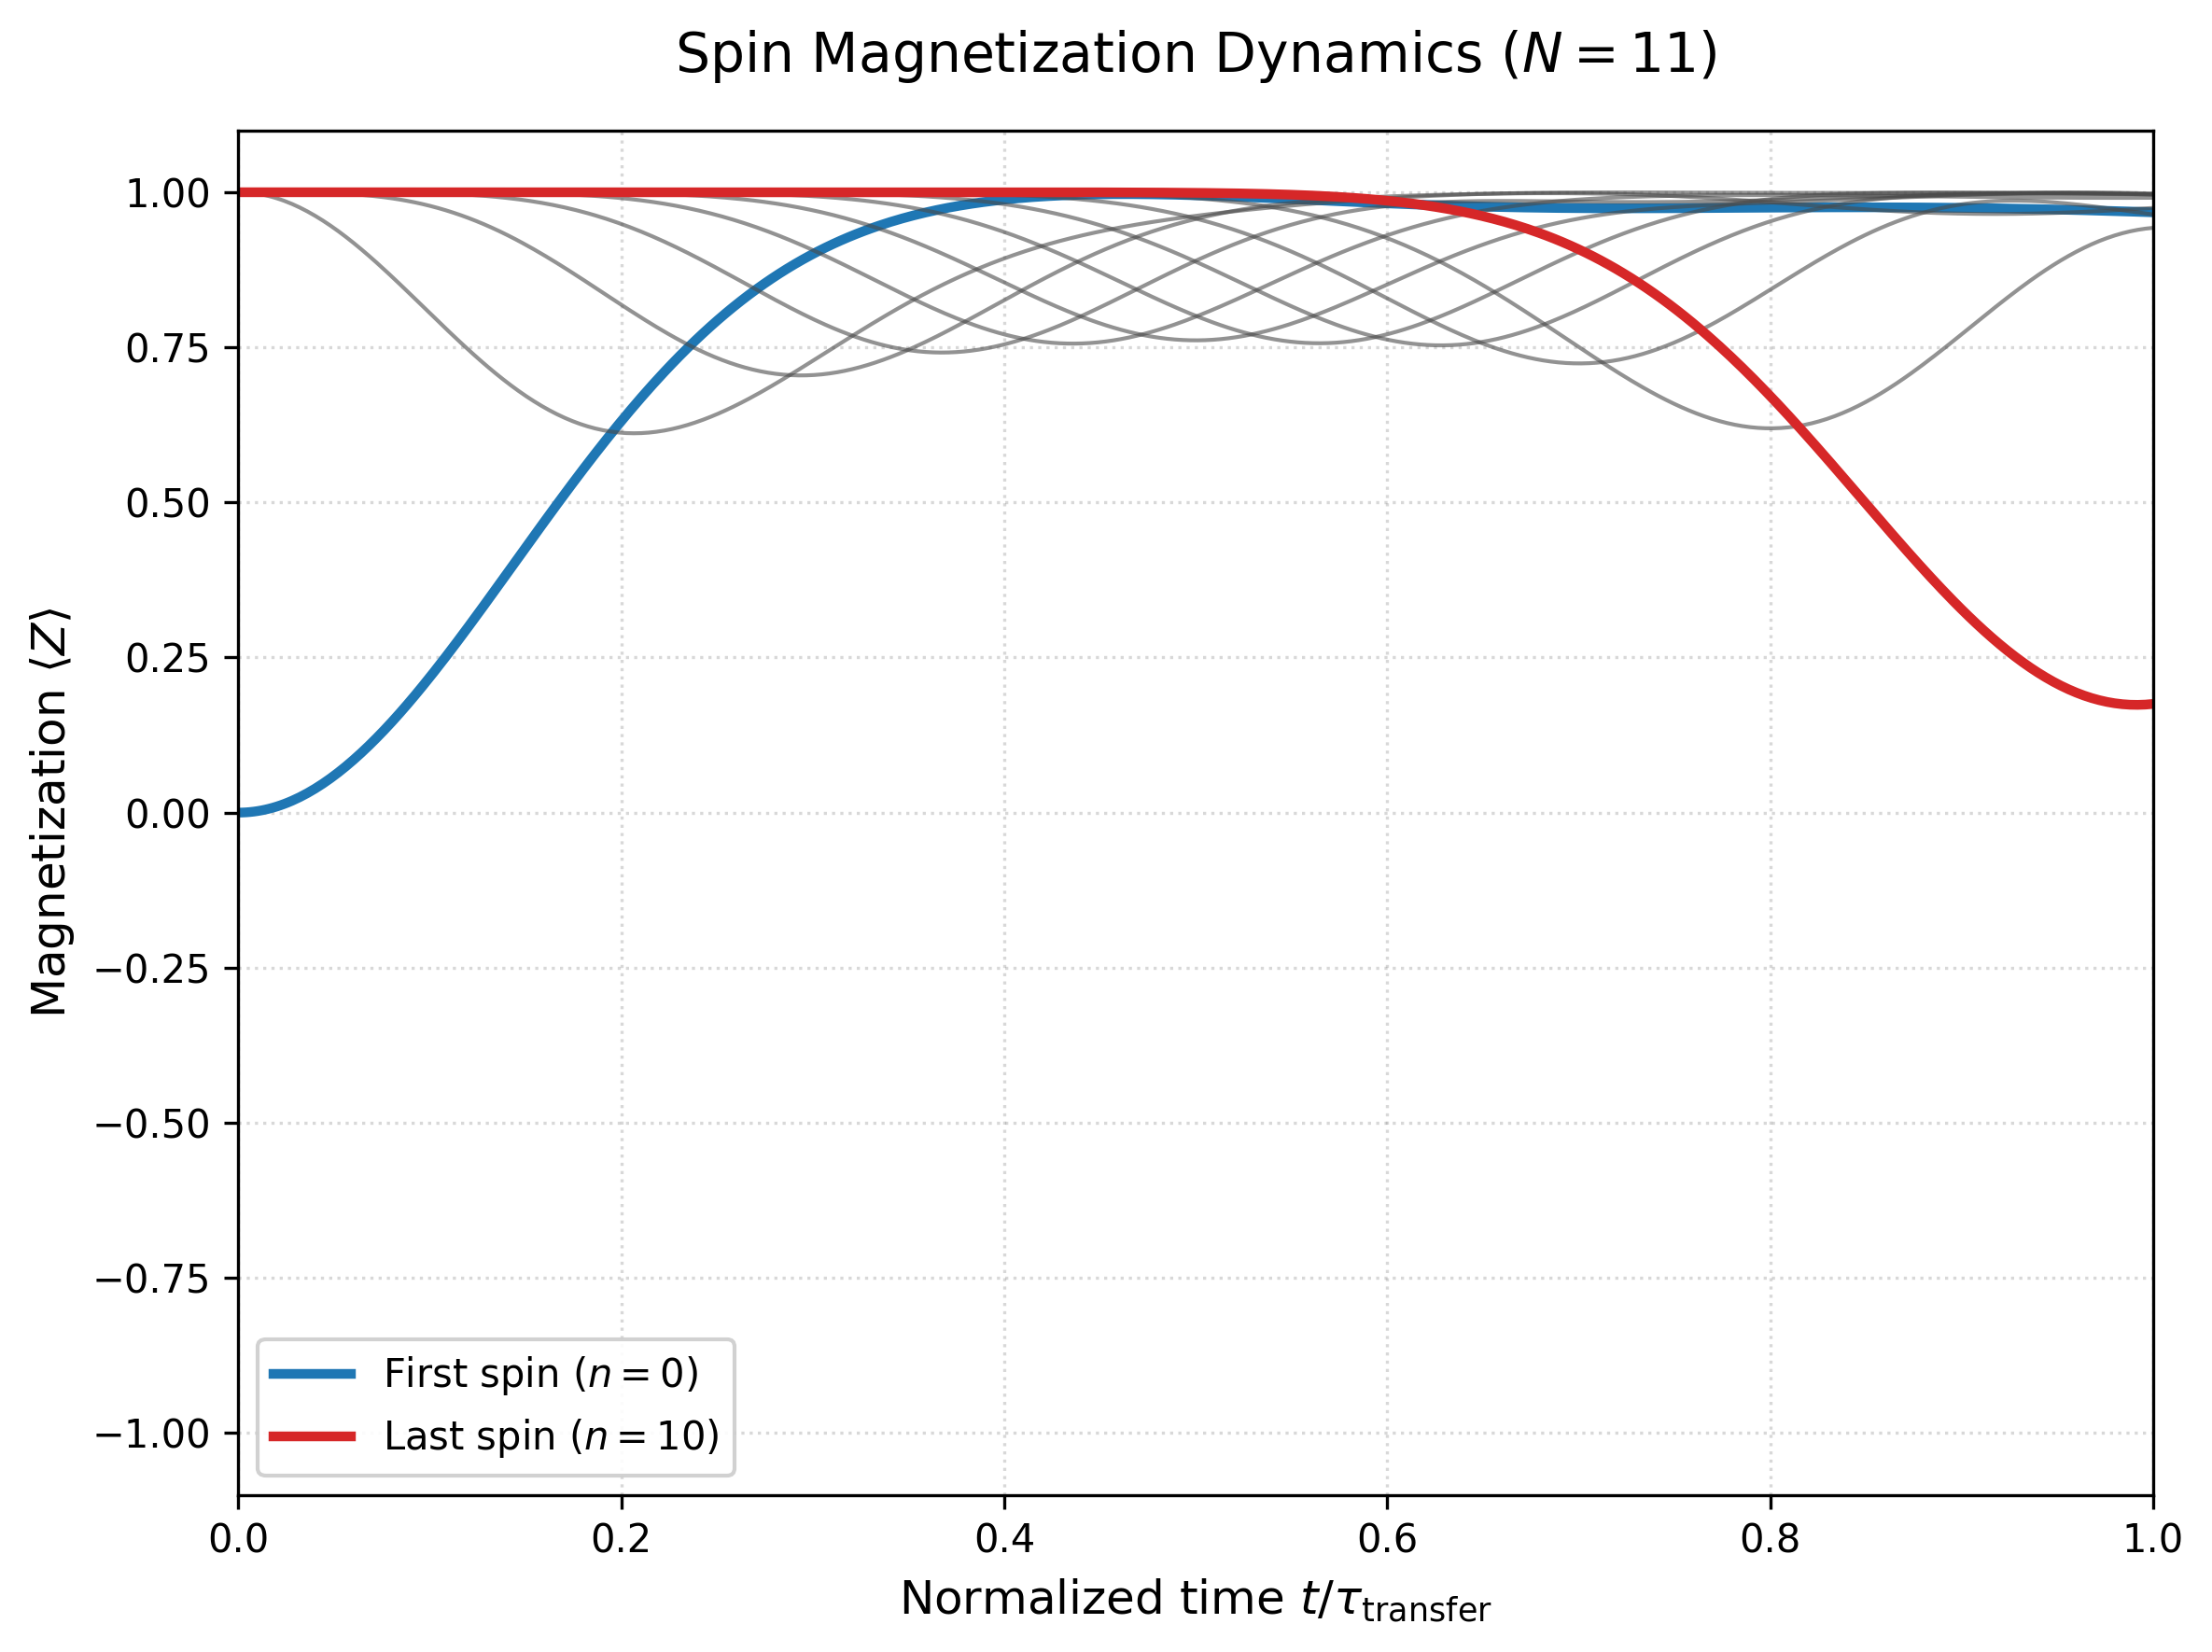

In [19]:
#Test plots
plots.plot_expectations(magnetizations["Sz"], N)